In [1]:
# run_inference_once.py
import torch
import numpy as np
from tqdm import tqdm
import pickle
import os
from utils.model import InkDetector
from utils.config import Config

def load_model_and_run_inference(
    model_path="models/best_model.pth",
    output_dir="inference_results",
    tile_size=32,  # Adjust based on your config
    depth=8,       # Adjust based on your config
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    """
    Run inference once and save results for later plotting experiments
    """
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Load model
    config = Config()
    print("Loading model...")
    model = InkDetector(config)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    model.to(device)
    
    # Load data
    print("Loading volumes...")
    train_volume, train_labels, valid_volume, valid_labels, labels = _load_tv_data(config)
    
    # Select one depth block (middle of the volume)
    D = train_volume.shape[0]
    depth_start = 0
    depth_end = 8
    
    print(f"Processing depth block: {depth_start}-{depth_end}")
    
    # Process training volume
    print("Processing training volume...")
    train_predictions = process_volume_depth_block(
        model, train_volume, depth_start, depth_end, tile_size, device
    )
    
    # Process validation volume
    print("Processing validation volume...")
    valid_predictions = process_volume_depth_block(
        model, valid_volume, depth_start, depth_end, tile_size, device
    )
    
    # Combine predictions
    full_predictions = np.concatenate([train_predictions, valid_predictions], axis=1)
    
    # Save results
    results = {
        'full_predictions': full_predictions,
        'train_predictions': train_predictions,
        'valid_predictions': valid_predictions,
        'labels': labels,
        'depth_start': depth_start,
        'depth_end': depth_end,
        'train_shape': train_volume.shape,
        'valid_shape': valid_volume.shape
    }
    
    output_path = os.path.join(output_dir, "inference_results.pkl")
    with open(output_path, 'wb') as f:
        pickle.dump(results, f)
    
    print(f"Results saved to: {output_path}")
    print(f"Prediction shapes - Train: {train_predictions.shape}, Valid: {valid_predictions.shape}")
    print(f"Full predictions shape: {full_predictions.shape}")
    
    return results

def process_volume_depth_block(model, volume, depth_start, depth_end, tile_size, device):
    """Process a single volume at a specific depth range"""
    D, H, W = volume.shape
    
    prediction_map = np.zeros((H, W), dtype=np.float32)
    count_map = np.zeros((H, W), dtype=np.float32)
    
    # Create list of all tile coordinates
    tile_coords = []
    for y in range(0, H - tile_size + 1, tile_size):
        for x in range(0, W - tile_size + 1, tile_size):
            tile_coords.append((y, x))
    
    # Pre-allocate tensor on GPU to avoid repeated allocations
    depth_size = depth_end - depth_start
    block_tensor = torch.zeros(
        (1, 1, depth_size, tile_size, tile_size),
        dtype=torch.float32,
        device=device
    )
    
    with torch.no_grad():
        for y, x in tqdm(tile_coords, desc=f"Processing tiles"):
            # Extract block from the specified depth range
            block = volume[depth_start:depth_end, y:y+tile_size, x:x+tile_size]
            
            if block.shape != (depth_size, tile_size, tile_size):
                continue
            
            # Copy data to pre-allocated tensor
            block_tensor[0, 0] = torch.from_numpy(block).float()
            
            logits = model(block_tensor)
            pred = torch.sigmoid(logits).item()
            
            prediction_map[y:y+tile_size, x:x+tile_size] += pred
            count_map[y:y+tile_size, x:x+tile_size] += 1
    
    # Clean up GPU memory
    del block_tensor
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Normalize predictions
    prediction_map = np.divide(prediction_map, count_map, where=count_map>0)
    return prediction_map

# if __name__ == "__main__":
#     # Update these paths to match your data
#     results = load_model_and_run_inference(
#         model_path="models/best_model.pth",
#     )

In [2]:
%matplotlib inline

In [9]:
# plotting_experiments.ipynb
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pickle
import os
from skimage.transform import rescale

# Load the saved inference results
def load_inference_results(results_path="inference_results/inference_results.pkl"):
    """Load the pre-computed inference results"""
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
    return results

# Load results once at the start
results = load_inference_results()
full_predictions = results['full_predictions']
train_predictions = results['train_predictions']
valid_predictions = results['valid_predictions']
labels = results['labels']
depth_start = results['depth_start']
depth_end = results['depth_end']

print(f"Loaded results:")
print(f"- Full predictions shape: {full_predictions.shape}")
print(f"- Train predictions shape: {train_predictions.shape}")
print(f"- Valid predictions shape: {valid_predictions.shape}")
print(f"- Labels shape: {labels.shape}")
print(f"- Depth range: {depth_start}-{depth_end}")
print(full_predictions.shape, train_predictions.shape, valid_predictions.shape, labels.shape)

# =============================================================================
# PLOTTING EXPERIMENTS - Modify these as needed
# =============================================================================
all_predictions_data = []
for i in range(4):
    all_predictions_data.append((full_predictions, train_predictions, i * 8, (i + 1) * 8))



Loaded results:
- Full predictions shape: (5400, 3600)
- Train predictions shape: (5400, 2700)
- Valid predictions shape: (5400, 900)
- Labels shape: (5400, 3600)
- Depth range: 0-8
(5400, 3600) (5400, 2700) (5400, 900) (5400, 3600)


In [7]:
from scipy.ndimage import zoom

In [14]:
def plot_version_1_scaled(scale_factor):    
    num_depth_blocks = len(all_predictions_data)
    
    # Calculate figure dimensions based on scaled data
    fig_height = 4 * num_depth_blocks
    fig_width = 5
    
    # Create subplots directly with minimal spacing
    fig, axes = plt.subplots(num_depth_blocks, 2, figsize=(fig_width, fig_height))
    
    # Handle single row case
    if num_depth_blocks == 1:
        axes = axes.reshape(1, -1)
    
    for block_idx, (full_predictions, train_predictions, depth_start, depth_end) in enumerate(all_predictions_data):
        
        # Scale the prediction arrays
        scaled_full_predictions = zoom(full_predictions, scale_factor, order=1)
        scaled_train_predictions = zoom(train_predictions, scale_factor, order=1)
        scaled_labels = zoom(labels, scale_factor, order=0)
        
        # Left plot: Model predictions
        ax_pred = axes[block_idx, 0]
        im1 = ax_pred.imshow(scaled_full_predictions, cmap='inferno', vmin=0, vmax=1, 
                            aspect='equal')
        ax_pred.set_title(f'Depth Block {depth_start}-{depth_end}', fontsize=9)
        
        # Adjust the dividing line position based on scaling
        train_split_pos = scaled_train_predictions.shape[1] - 0.5
        ax_pred.axvline(x=train_split_pos, color='red', linestyle='--', linewidth=1.2)
        ax_pred.axis('off')
        
        # Right plot: Predictions + Ground Truth overlay
        ax_overlay = axes[block_idx, 1]
        ax_overlay.imshow(scaled_full_predictions, cmap='inferno', vmin=0, vmax=1, 
                         aspect='equal')
        
        if scaled_labels is not None:
            label_overlay = np.zeros((*scaled_labels.shape, 4))
            label_overlay[scaled_labels > 0.5] = [1, 1, 1, 0.4]  # White with 40% opacity
            ax_overlay.imshow(label_overlay)
        
        ax_overlay.axvline(x=train_split_pos, color='red', linestyle='--', linewidth=1.2)
        ax_overlay.axis('off')
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1, left=0.1, right=0.9, top=0.9, bottom=0.1)
    plt.show()
    plt.close(fig)

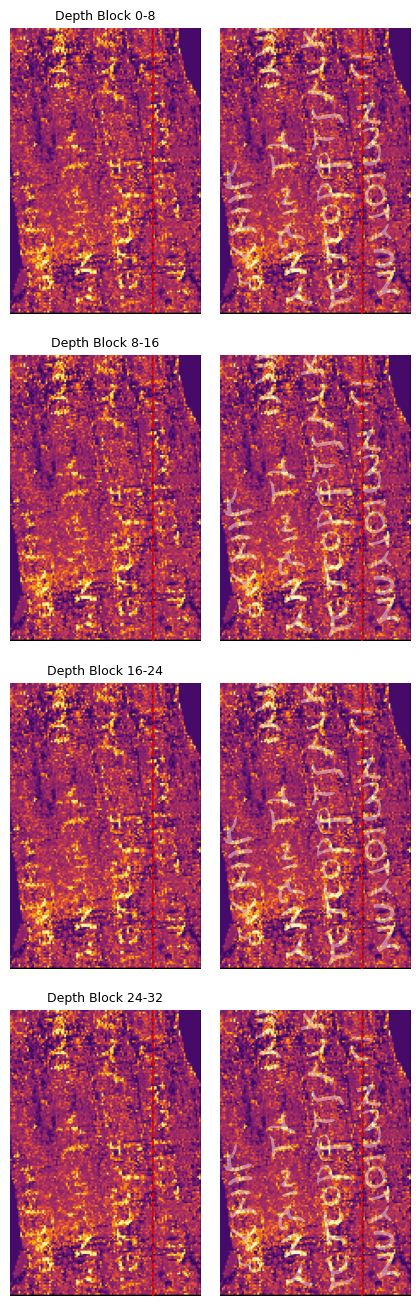

In [15]:
plot_version_1_scaled(0.3)
